In [438]:
import sys
sys.path.append("..")

import Essentials

In [439]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [440]:
data_archive = np.load('../Data_Average.npz', allow_pickle=True)

In [441]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [442]:
X_test_1 = data_archive['X_test_1']
X_train_1 = data_archive['X_train_1']

X_test_2 = data_archive['X_test_2']
X_train_2 = data_archive['X_train_2']

X_test_3 = data_archive['X_test_3']
X_train_3 = data_archive['X_train_3']

Y_test_1, timestamp_test_1 = prepare_Y(data_archive['Y_test_1'])
Y_train_1, timestamp_train_1 = prepare_Y(data_archive['Y_train_1'])

Y_test_2, timestamp_test_2 = prepare_Y(data_archive['Y_test_2'])
Y_train_2, timestamp_train_2 = prepare_Y(data_archive['Y_train_2'])

Y_test_3, timestamp_test_3 = prepare_Y(data_archive['Y_test_3'])
Y_train_3, timestamp_train_3 = prepare_Y(data_archive['Y_train_3'])

C:\Users\PC\AppData\Local\Temp\ipykernel_8004\4096890530.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = y.astype(np.float64)


In [443]:
class PCA_LR(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, n_components):
        super().__init__(name)
        self.model = LinearRegression()
        self.x_pca = PCA(n_components)
        self.fit_pca(x_train)
        self.train(x_train, y_train)
        self.set_model(self.model)

    def preprocessing(self, x):
        try:
            return self.x_pca.transform(x)
        except Exception as err:
            print("Ошибка трансформации данных:", err)           
    
    def postprocessing(self, x):
        return x

    def fit_pca(self, x):
        self.x_pca.fit(x)

    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions

    def train(self, x_train, y_train):
        x_train_pca = self.preprocessing(x_train)
        self.model.fit(x_train_pca,y_train)

    def __str__(self):
        return  f"Коэффициенты линейной регрссии = {self.get_model().coef_.reshape(-1,1)}, Свободный член = {self.get_model().intercept_.reshape(-1, 1)}"

In [444]:
PCA_LR_test = PCA_LR("PCA_LR" ,X_train_2, Y_train_2, 18)

In [445]:
metric = Essentials.R2Metric()

In [446]:
print(PCA_LR_test)

Коэффициенты линейной регрссии = [[-0.00182561]
 [ 0.0294457 ]
 [-0.05985283]
 [-0.0410162 ]
 [-0.17293271]
 [ 0.44211839]
 [-0.17355875]
 [-0.04039416]
 [ 0.39851168]
 [-0.18510623]
 [ 0.17112497]
 [-0.34313368]
 [ 0.70403027]
 [-0.6352424 ]
 [-0.53724389]
 [-0.35543392]
 [ 0.63406873]
 [-0.0784265 ]], Свободный член = [[90.26666667]]


In [447]:
PCA_LR_test.test(X_test_2, Y_test_2, metric)

(array([[ 78.49089506],
        [ 97.27387808],
        [ 96.79526757],
        [ 64.58228415],
        [ 78.22001461],
        [ 80.69812457],
        [ 80.06190873],
        [ 83.28869823],
        [ 80.46132213],
        [ 81.07048989],
        [ 81.47981637],
        [ 77.27967013],
        [ 82.41783584],
        [ 90.3913538 ],
        [ 90.97695065],
        [ 82.24420856],
        [ 87.16786996],
        [ 83.46636933],
        [ 85.46659345],
        [ 88.44297278],
        [ 85.66680538],
        [ 83.10544966],
        [ 81.4935816 ],
        [ 86.78633474],
        [ 92.86650814],
        [ 83.26908703],
        [ 83.11557739],
        [ 94.06903143],
        [ 88.79493731],
        [ 86.90355516],
        [ 83.07858999],
        [ 80.81877827],
        [ 87.99018495],
        [104.35689821],
        [ 89.60304897]]),
 0.4830649237037743)

In [448]:
PCA_LR_test_visual_train = Essentials.Visualizer(X_train_2, Y_train_2, timestamp_train_2, [metric], 'Linear with PCA SoftSensor R2 metric on Train')

        Coefficient of determination
PCA_LR                      0.603926


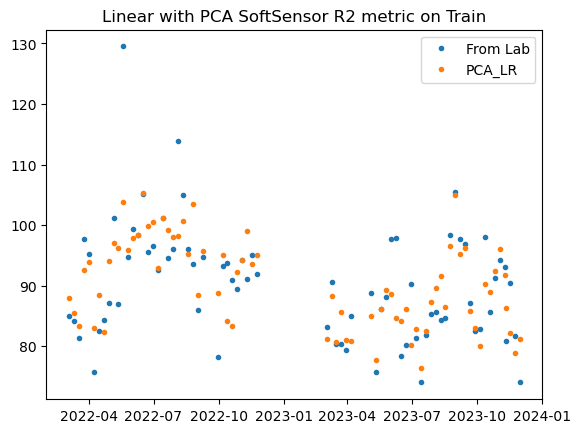

In [449]:
PCA_LR_test_visual_train.visualize([PCA_LR_test])

In [450]:
PCA_LR_test_visual_test = Essentials.Visualizer(X_test_2, Y_test_2, timestamp_test_2, [metric], 'Linear with PCA SoftSensor R2 metric on Test')

        Coefficient of determination
PCA_LR                      0.483065


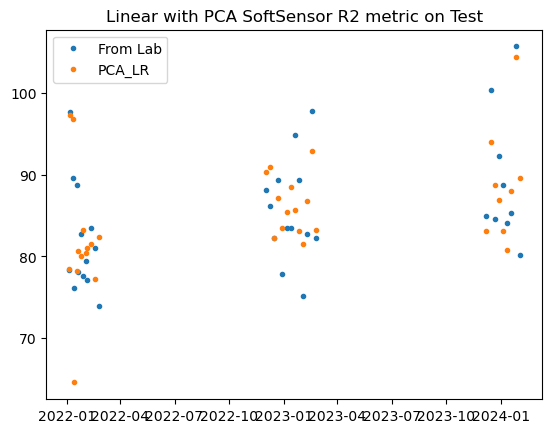

In [451]:
PCA_LR_test_visual_test.visualize([PCA_LR_test])